In [1]:
import torch
import torch.nn.functional as F

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli

In [3]:
def cross_entropy(output, target):
    logits = output[torch.arange(len(output)), target]
    loss = - logits + torch.log(torch.sum(torch.exp(output), axis=-1))
    loss = loss.mean()
    return loss

In [4]:
df = pd.DataFrame(columns=['X1', 'X2'])

In [5]:
df.X1 = np.random.randint(2, size=10**3)
df.X2 = np.random.randint(2, size=10**3)

In [6]:
a = torch.Tensor(df.X1.to_numpy())
b = torch.Tensor(df.X2.to_numpy())

loss = torch.nn.CrossEntropyLoss()
loss(a, b)

C:\Users\joanb\AppData\Local\Temp\ipykernel_2148\747186736.py:1: UserWarning: Failed to initialize NumPy: module compiled against API version 0x10 but this version of numpy is 0xf (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:68.)
  a = torch.Tensor(df.X1.to_numpy())


tensor(3417.5635)

# 1. DATA: TOY EXAMPLE

In [7]:
X = np.random.rand(10**3,2)
df = pd.DataFrame(X, columns=['X1', 'X2'])
df.head(5)

,X1,X2
0,0.457633,0.274310
1,0.170258,0.905733
2,0.426743,0.067306
3,0.033611,0.259964
4,0.726409,0.747385


In [8]:
df['Sin'] = np.sin((df.X1 + df.X2))
df['pdiv'] = (df.X1 + df.X2)**2/(1 + (df.X1 + df.X2)**2)

In [9]:
df.head(10)

,X1,X2,Sin,pdiv
0,0.457633,0.274310,0.668316,0.348848
1,0.170258,0.905733,0.880061,0.536556
2,0.426743,0.067306,0.474195,0.196196
3,0.033611,0.259964,0.289376,0.079348
4,0.726409,0.747385,0.995299,0.684748
5,0.222262,0.317026,0.513525,0.225305
6,0.877897,0.885155,0.981576,0.756594
7,0.313593,0.287273,0.565357,0.265267
8,0.565696,0.173850,0.673952,0.353557
9,0.201766,0.310177,0.489872,0.207661


In [10]:
df['Y1'] = bernoulli.rvs(df.Sin)
df['Y2'] = bernoulli.rvs(df.pdiv)
df.head(10)
df.to_csv('data_test')

# 2. Neural Network

In [11]:
df_t = torch.Tensor(df[['X1', 'X2']].values)
y1 = torch.Tensor(df[['Y1']].values)
y2 = torch.Tensor(df[['Y2']].values)

In [118]:
model1 = torch.nn.Sequential(
    torch.nn.Linear(2,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.Sigmoid()
)

model2 = torch.nn.Sequential(
    torch.nn.Linear(2,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
    torch.nn.Sigmoid()
)


criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.8)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.3)

In [92]:
# ejemplo de como funciona el gumbel softmax

#F.gumbel_softmax(model(df_t).log(), hard=False)
#model(df_t).log()

logits = torch.randn(10, 5)
F.gumbel_softmax(logits, hard=True)

tensor([[1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [0., 1., 0., 0., 0.],
        [0., 0., 1., 0., 0.],
        [1., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0.]])

In [93]:
F.gumbel_softmax(torch.Tensor([0.1, 0.9]).log(), tau=1, hard=True)

tensor([0., 1.])

In [94]:
y_pred_0 = model1(df_t)
y_pred_1 = 1 - model1(df_t)

y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

aux = F.gumbel_softmax(y_pred.log(), hard=True)
aux

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]], grad_fn=<AddBackward0>)

In [95]:
criterion1(y1, aux[:, 0].reshape(1000,1))

tensor(0.5550, grad_fn=<MseLossBackward0>)

In [96]:
epochs = 10**5
log_each = 1000
l = []
model1.train()

for e in range(1, epochs + 1):
    y_pred_0 = model1(df_t)
    y_pred_1 = 1 - model1(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

    y_pred = F.gumbel_softmax(y_pred.log(), hard=True)

    loss = criterion1(y_pred[:, 0].reshape(1000, 1), y1)
    l.append(loss.item())

    optimizer1.zero_grad()

    loss.backward()

    optimizer1.step()

    if not e % log_each:
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f}')
    

Epoch 1000/100000 Loss 0.23742
Epoch 2000/100000 Loss 0.22647
Epoch 3000/100000 Loss 0.22272
Epoch 4000/100000 Loss 0.22095
Epoch 5000/100000 Loss 0.21982
Epoch 6000/100000 Loss 0.21909
Epoch 7000/100000 Loss 0.21861
Epoch 8000/100000 Loss 0.21829
Epoch 9000/100000 Loss 0.21806
Epoch 10000/100000 Loss 0.21784
Epoch 11000/100000 Loss 0.21766
Epoch 12000/100000 Loss 0.21749
Epoch 13000/100000 Loss 0.21738
Epoch 14000/100000 Loss 0.21728
Epoch 15000/100000 Loss 0.21716
Epoch 16000/100000 Loss 0.21709
Epoch 17000/100000 Loss 0.21703
Epoch 18000/100000 Loss 0.21694
Epoch 19000/100000 Loss 0.21689
Epoch 20000/100000 Loss 0.21682
Epoch 21000/100000 Loss 0.21678
Epoch 22000/100000 Loss 0.21672
Epoch 23000/100000 Loss 0.21667
Epoch 24000/100000 Loss 0.21665
Epoch 25000/100000 Loss 0.21660
Epoch 26000/100000 Loss 0.21657
Epoch 27000/100000 Loss 0.21656
Epoch 28000/100000 Loss 0.21653
Epoch 29000/100000 Loss 0.21651
Epoch 30000/100000 Loss 0.21649
Epoch 31000/100000 Loss 0.21648
Epoch 32000/10000

In [97]:
y_hat1 = np.zeros(model1(df_t).shape)

cont = 0
for value in model1(df_t):
    y_hat1[cont] = value.item()
    cont +=1

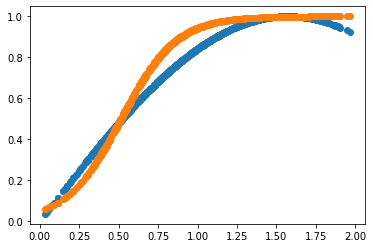

In [98]:
plt.scatter(df.X1.values + df.X2.values, np.sin(df.X1.values + df.X2.values))
plt.scatter(df.X1.values + df.X2.values, y_hat1, cmap='red')

In [102]:
y_pred_0 = model2(df_t)
y_pred_1 = 1 - model2(df_t)

y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)
y_pred = F.gumbel_softmax(y_pred.log(), hard=True)

y_pred

tensor([[0., 1.],
        [0., 1.],
        [1., 0.],
        ...,
        [0., 1.],
        [1., 0.],
        [0., 1.]], grad_fn=<AddBackward0>)

In [103]:
loss = criterion2(y_pred[:, 0].reshape(1000, 1), y2)
loss

tensor(0.5150, grad_fn=<MseLossBackward0>)

In [104]:
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.2)

In [119]:
epochs = 4*10**5
log_each = 1000
l = []
model2.train()

for e in range(1, epochs + 1):
    y_pred_0 = model2(df_t)
    y_pred_1 = 1 - model2(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

    y_pred = F.gumbel_softmax(y_pred.log(), hard=True)

    loss = criterion2(y_pred[:, 0].reshape(1000, 1), y2)
    l.append(loss.item())

    optimizer2.zero_grad()

    loss.backward()

    optimizer2.step()

    if not e % log_each:
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f}')

Epoch 1000/400000 Loss 0.43707
Epoch 2000/400000 Loss 0.41558
Epoch 3000/400000 Loss 0.40798
Epoch 4000/400000 Loss 0.40377
Epoch 5000/400000 Loss 0.40142
Epoch 6000/400000 Loss 0.39941
Epoch 7000/400000 Loss 0.39776
Epoch 8000/400000 Loss 0.39624
Epoch 9000/400000 Loss 0.39485
Epoch 10000/400000 Loss 0.39363
Epoch 11000/400000 Loss 0.39254
Epoch 12000/400000 Loss 0.39155
Epoch 13000/400000 Loss 0.39067
Epoch 14000/400000 Loss 0.38991
Epoch 15000/400000 Loss 0.38926
Epoch 16000/400000 Loss 0.38861
Epoch 17000/400000 Loss 0.38811
Epoch 18000/400000 Loss 0.38767
Epoch 19000/400000 Loss 0.38724
Epoch 20000/400000 Loss 0.38688
Epoch 21000/400000 Loss 0.38656
Epoch 22000/400000 Loss 0.38624
Epoch 23000/400000 Loss 0.38597
Epoch 24000/400000 Loss 0.38574
Epoch 25000/400000 Loss 0.38550
Epoch 26000/400000 Loss 0.38529
Epoch 27000/400000 Loss 0.38509
Epoch 28000/400000 Loss 0.38489
Epoch 29000/400000 Loss 0.38469
Epoch 30000/400000 Loss 0.38453
Epoch 31000/400000 Loss 0.38438
Epoch 32000/40000

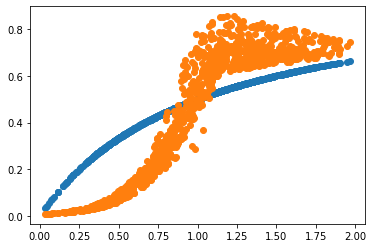

In [120]:
y_hat2 = np.zeros(model2(df_t).shape)

cont = 0
for value in model2(df_t):
    y_hat2[cont] = value.item()
    cont +=1
x = df.X1.values + df.X2.values    
plt.scatter(x, x/(1 + x))
plt.scatter(x, y_hat2, cmap='red')

## 2.1 Usando Monte-Carlo

In [12]:
model1 = torch.nn.Sequential(
    torch.nn.Linear(2,4),
    torch.nn.ReLU(),
    torch.nn.Linear(4,1),
    torch.nn.Sigmoid()
)

model2 = torch.nn.Sequential(
    torch.nn.Linear(2,10),
    torch.nn.ReLU(),
    torch.nn.Linear(10,1),
    torch.nn.Sigmoid()
)


criterion1 = torch.nn.MSELoss()
criterion2 = torch.nn.MSELoss()
optimizer1 = torch.optim.SGD(model1.parameters(), lr=0.8)
optimizer2 = torch.optim.SGD(model2.parameters(), lr=0.3)

In [23]:
N = 10**2
y_pred_0 = model1(df_t)
y_pred_1 = 1 - model1(df_t)

y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

y_pred = F.gumbel_softmax(y_pred.log(), hard=True)

for i in range(1, N):
    y_pred += F.gumbel_softmax(y_pred.log(), hard=True)

y_pred = y_pred/2*N

y_pred

tensor([[   0., 5000.],
        [   0., 5000.],
        [5000.,    0.],
        ...,
        [5000.,    0.],
        [   0., 5000.],
        [   0., 5000.]], grad_fn=<MulBackward0>)

In [14]:
N = 10**2
epochs = 10**4
log_each = 100
l = []
model1.train()

for e in range(1, epochs + 1):
    y_pred_0 = model1(df_t)
    y_pred_1 = 1 - model1(df_t)

    y_pred = torch.stack((y_pred_0, y_pred_1), -1).reshape(1000,2)

    y_pred = F.gumbel_softmax(y_pred.log(), hard=True)

    for i in range(1, N):
        y_pred += F.gumbel_softmax(y_pred.log(), hard=True)
    
    y_pred = y_pred/N

    loss = criterion1(y_pred[:, 0].reshape(1000, 1), y1)
    l.append(loss.item())

    optimizer1.zero_grad()

    loss.backward()

    optimizer1.step()

    if not e % log_each:
        print(f'Epoch {e}/{epochs} Loss {np.mean(l):.5f}')
    

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.FloatTensor [1000, 2]], which is output 0 of AddBackward0, is at version 99; expected version 98 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

# 3. Gumbel-Softmax

In [ ]:
logits = torch.randn(20, 32)
logits

tensor([[ 7.6489e-01, -6.6671e-01, -1.2384e-01,  1.2796e+00,  3.8441e-01,
         -3.6823e-03,  6.3410e-01,  2.8906e-01, -1.8588e+00, -3.9752e-01,
         -1.9323e-01,  1.7230e-01, -1.5909e+00, -1.6632e+00,  1.7779e+00,
         -1.3180e+00,  1.5212e-01, -1.2113e+00,  1.3388e+00,  3.7228e-01,
          1.0506e+00, -9.5167e-01, -2.0212e+00,  5.3694e-01, -4.0040e-01,
          5.9770e-01,  2.6239e-01,  2.4333e+00, -4.5926e-02,  1.0183e+00,
          2.4635e+00, -7.3983e-01],
        [-2.2115e-01,  7.8617e-01, -2.6264e-03,  7.1794e-01,  2.9646e-02,
         -2.6005e-02, -9.6798e-01,  7.4989e-01,  1.0117e+00,  2.9135e-02,
         -2.5381e-02,  6.7920e-01, -6.7292e-01, -1.5750e+00,  4.0203e-01,
         -4.0640e-01, -9.7063e-01, -5.1587e-01,  2.8869e-01,  6.7551e-01,
         -7.6901e-01,  9.7987e-01, -8.6513e-01, -1.2525e-01,  1.2387e+00,
          4.4873e-01,  1.4693e-01, -1.7503e+00, -2.0142e+00,  1.1206e+00,
          4.3872e-01, -2.2206e-01],
        [ 1.0507e+00,  2.1556e+00, -1.15

In [ ]:
torch.nn.functional.gumbel_softmax(torch.Tensor([0.5, 0.5]).log(), hard=True)

tensor([0., 1.])